* ! pip install tensorflow
* ! pip install Pillow
* ! pip install matplotlib
* ! pip install opencv-python

In [87]:
import numpy as np
import cv2
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import layers, models



from PIL import Image
import glob

import matplotlib.pyplot as plt


In [88]:
## Cargar el conjunto de datos MIAS
# Nota: Asegúrate de adaptar la función de carga según tu necesidad y estructura de datos
def load_mias_data(directory='data/data/mias-mammography/all-mias-roi'):
    images = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.pgm'):  # Asume que las imágenes están en formato .pgm, cambia según corresponda
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256))  # Cambia el tamaño de la imagen si es necesario

            images.append(img)

            # Aquí puedes añadir etiquetas si las tienes. Por ahora, solo añadiré 0 como etiqueta ficticia
            labels.append(0)

    return (np.array(images), np.array(labels)), (None, None)  # Retorna imágenes y etiquetas, y por ahora 'None' para el conjunto de validación

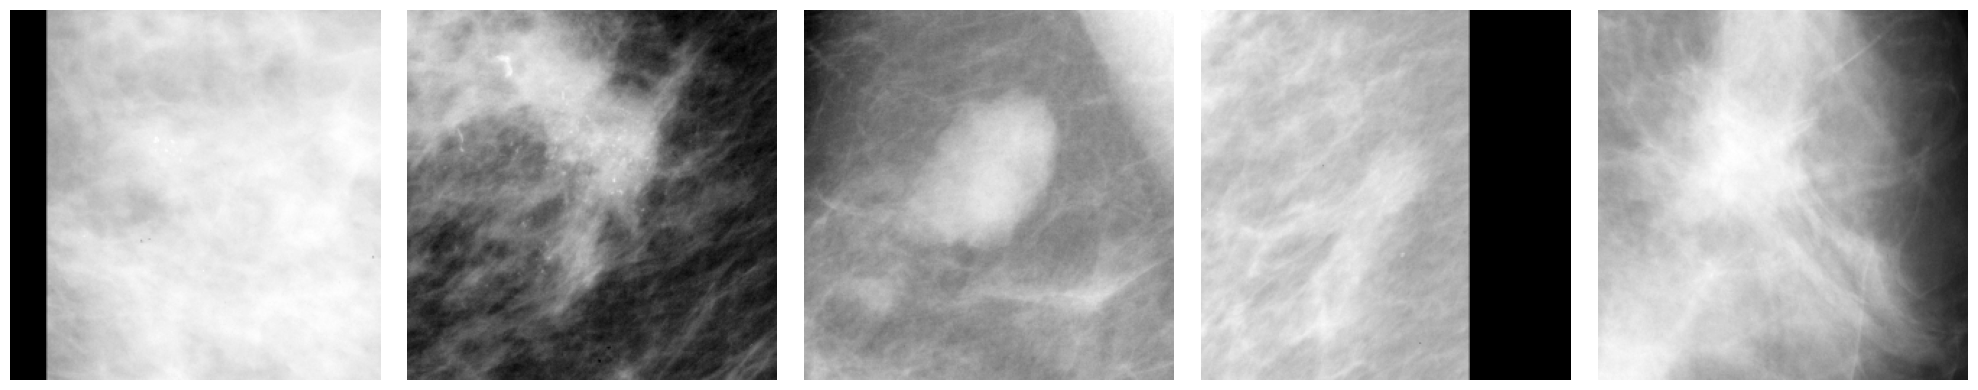

In [89]:
def visualize_random_images(images, num_images=5):
    selected_images = random.sample(list(images), num_images)
    
    plt.figure(figsize=(20, 4))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Cargar las imágenes
(x_train, _), _ = load_mias_data()

# Visualizar 10 imágenes aleatorias
visualize_random_images(x_train)

In [90]:
(x_train, _), (_, _) = load_mias_data()
x_train = x_train.astype('float32') / 255.0

In [91]:
# Bloque básico para el generador
def generator_block(filters, kernel_size, upsampling=False):
    block = models.Sequential()
    if upsampling:
        block.add(layers.UpSampling2D())
    block.add(layers.Conv2D(filters, kernel_size, padding="same"))
    block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU())
    return block

In [92]:
# Bloque básico para el discriminador
def discriminator_block(filters, kernel_size, downsampling=False):
    block = models.Sequential()
    block.add(layers.Conv2D(filters, kernel_size, padding="same"))
    block.add(layers.BatchNormalization())
    block.add(layers.LeakyReLU())
    if downsampling:
        block.add(layers.AveragePooling2D())
    return block

In [93]:
def expand_generator(model):
    # Encontrar la última capa Conv2D
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            last_conv_layer = layer
            break
            
    if last_conv_layer is None:
        raise ValueError("No se encontró una capa Conv2D.")
        
    filters = last_conv_layer.filters // 2
    # Comprobar y establecer un mínimo para 'filters'
    filters = max(filters, 32)  # Ajustar según tus necesidades
    kernel_size = (3, 3)
    
    # Añadir bloques al modelo
    model.add(generator_block(filters, kernel_size, upsampling=True))
    model.add(layers.Conv2D(1, (1, 1), activation="sigmoid"))
    return model

def expand_discriminator(model):
    # Encontrar la primera capa Conv2D
    first_conv_layer = None
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D):
            first_conv_layer = layer
            break
            
    if first_conv_layer is None:
        raise ValueError("No se encontró una capa Conv2D.")
        
    filters = first_conv_layer.filters * 2
    # Comprobar y establecer un máximo para 'filters'
    filters = min(filters, 512)  # Ajustar según tus necesidades
    kernel_size = (3, 3)
    
    new_model = models.Sequential()
    new_model.add(discriminator_block(filters, kernel_size, downsampling=True))
    for layer in model.layers:
        new_model.add(layer)
    return new_model

In [94]:
# Crear modelos iniciales
generator = generator_block(128, (4, 4))
generator.add(layers.Conv2D(1, (1, 1), activation="sigmoid"))

discriminator = models.Sequential()
discriminator.add(layers.Input(shape=(4, 4, 1)))
discriminator.add(discriminator_block(128, (4, 4)))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Dense(1, activation="sigmoid"))

In [95]:
# Compilar modelos
opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
discriminator.trainable = False
gan = models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer=opt)

In [96]:
def train_gan(generator, discriminator, gan, x_train, epochs, batch_size, resolution):
    # Asumimos que el dataset ya está adecuadamente escalado para la resolución dada
    
    # Etiquetas reales y falsas
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Seleccionar un lote de imágenes reales
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]
        
        # Generar un lote de nuevas imágenes
        noise = np.random.normal(0, 1, (batch_size, generator.input_shape[1]))
        generated_imgs = generator.predict(noise)
        
        # Entrenar el discriminador
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(generated_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Entrenar el generador
        g_loss = gan.train_on_batch(noise, valid)
        
        # Imprimir el progreso
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")
        
        # Opcional: Guardar imágenes generadas y/o modelos en ciertos intervalos
        # ...
    
    # Guardar los modelos al final del entrenamiento
    generator.save(f"generator_{resolution}.h5")
    discriminator.save(f"discriminator_{resolution}.h5")

In [97]:
# Función para escalar el conjunto de datos a la resolución dada
def resize_dataset(x_train, resolution):
    resized_data = np.array([cv2.resize(img, (resolution, resolution)) for img in x_train])
    return resized_data[..., np.newaxis]  # Añade la dimensión del canal si es necesario


In [98]:
# Ciclo principal de entrenamiento con progressive growing
resolutions = [4, 8, 16, 32, 64, 128, 256]
for resolution in resolutions:
    # Adecuar el dataset para la resolución actual
    # Por ejemplo, usando cv2.resize o similar
    current_dataset = resize_dataset(x_train, resolution)
    
    # Entrenar la GAN en la resolución actual
    train_gan(generator, discriminator, gan, current_dataset, epochs=10000, batch_size=128, resolution=resolution)
    
    # Expandir los modelos si no es la última resolución
    if resolution != resolutions[-1]:
        generator = expand_generator(generator)
        discriminator = expand_discriminator(discriminator)

AttributeError: 'Sequential' object has no attribute '_nested_inputs'

In [ ]:
def generate_and_visualize_images(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 128))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Genera y visualiza 10 imágenes después de entrenar la GAN
generate_and_visualize_images(generator, num_images=10)